# GDS

## GDS output

GDS files are great for describing geometry thanks to the concept of References, where you store any geometry only once in memory.

For storing device metadata (settings, port locations, port widths, port angles ...) there is no clear standard.

`gdsfactory` stores the that metadata in `YAML` files, and also has functions to add pins

- `Component.write_gds()` saves GDS
- `Component.write_gds_metadata()` save GDS + YAML metadata

2022-05-02 16:31:45.681 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.3.8


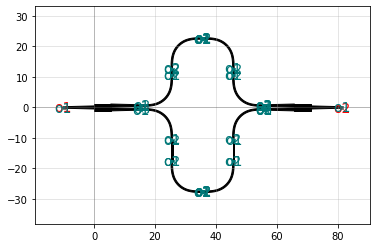

mzi: uid 3, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references

In [1]:
import gdsfactory as gf

c = gf.components.mzi()
c

You can write **GDS** files only

In [2]:
gdspath = c.write_gds("extra/mzi.gds")

2022-05-02 16:31:47.918 | INFO     | gdsfactory.component:write_gds:956 - Write GDS to 'extra/mzi.gds'


Or **GDS** with **YAML** metadata information (ports, settings, cells ...)

In [3]:
gdspath = c.write_gds_with_metadata("extra/mzi.gds")

2022-05-02 16:31:47.928 | INFO     | gdsfactory.component:write_gds:956 - Write GDS to 'extra/mzi.gds'


2022-05-02 16:31:48.147 | INFO     | gdsfactory.component:write_gds_with_metadata:964 - Write YAML metadata to 'extra/mzi.yml'


This created a `mzi.yml` file that contains:
- ports
- cells (flat list of cells)
- info (function name, module, changed settings, full settings, default settings)

In [4]:
c.metadata.keys()

dict_keys(['name', 'module', 'function_name', 'info', 'info_version', 'full', 'changed', 'default', 'child'])

## GDS input

You can read GDS files into gdsfactory thanks to the `import_gds` function

### GDS input + YAML metadata

`import_gds` reads the same GDS file from disk without losing any information

2022-05-02 16:31:48.175 | INFO     | gdsfactory.read.import_gds:import_gds:187 - Read YAML metadata from extra/mzi.yml


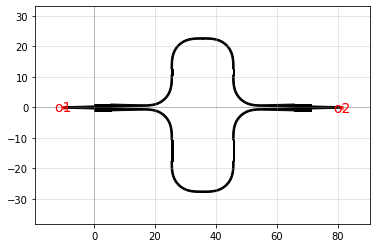

mzi: uid 21, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references

In [5]:
gf.clear_cache()

c = gf.import_gds(gdspath)
c

2022-05-02 16:31:48.569 | INFO     | gdsfactory.read.import_gds:import_gds:187 - Read YAML metadata from extra/mzi.yml


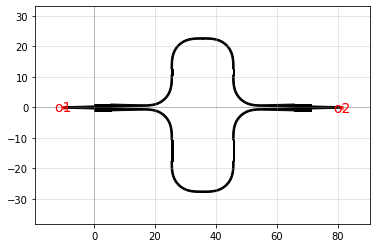

mzi_sample: uid 31, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references

In [6]:
import gdsfactory as gf

c2 = gf.import_gds(gdspath, name="mzi_sample")
c2

In [7]:
c2.name

'mzi_sample'

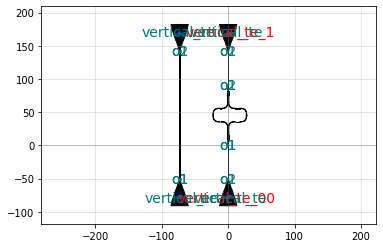

mzi_move_400da4ae_add_f_46730d0c: uid 44, ports ['vertical_te_00', 'vertical_te_1'], aliases [], 0 polygons, 8 references

In [8]:
c3 = gf.routing.add_fiber_single(c2)
c3

In [9]:
gdspath = c3.write_gds_with_metadata("extra/pdk.gds")

2022-05-02 16:31:49.415 | INFO     | gdsfactory.component:write_gds:956 - Write GDS to 'extra/pdk.gds'


2022-05-02 16:31:49.600 | INFO     | gdsfactory.component:write_gds_with_metadata:964 - Write YAML metadata to 'extra/pdk.yml'


In [10]:
gf.mask.write_labels(gdspath, layer_label=gf.LAYER.LABEL)

2022-05-02 16:31:49.612 | INFO     | gdsfactory.mask.write_labels:write_labels:81 - Wrote 4 labels in /home/runner/work/gdsfactory/gdsfactory/docs/notebooks/extra/pdk.csv


PosixPath('extra/pdk.csv')

### GDS input + port pins

Sometimes the GDS does not have YAML metadata, therefore you need to figure out the port locations, widths and orientations.

gdsfactory provides you with functions that will add ports to the component by looking for pins shapes on a specific layers.

There are different pin standards supported to automatically add ports to components:

- PINs towards the inside of the port (port at the outer part of the PIN)
- PINs with half of the pin inside and half outside (port at the center of the PIN)
- PIN with only labels (no shapes). You have to manually specify the width of the port.


Lets add pins, save a GDS and then import it back.

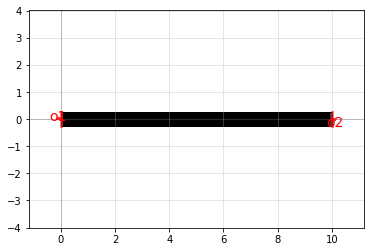

straight_1514d1a3: uid 56, ports ['o1', 'o2'], aliases [], 3 polygons, 0 references

In [11]:
import gdsfactory as gf

c = gf.components.straight(decorator=gf.add_pins)  # add pins inside the component
c

In [12]:
gdspath = c.write_gds("extra/wg.gds")

2022-05-02 16:31:49.911 | INFO     | gdsfactory.component:write_gds:956 - Write GDS to 'extra/wg.gds'


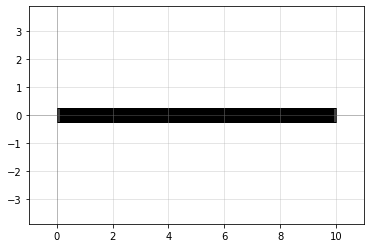

straight_1514d1a3: uid 58, ports [], aliases [], 3 polygons, 0 references

In [13]:
gf.clear_cache()
c2 = gf.import_gds(gdspath)
c2

In [14]:
c2.ports  # import_gds does not automatically add the pins

{}

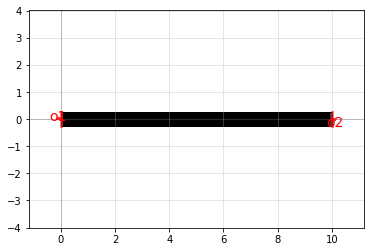

straight_1514d1a3: uid 59, ports ['o1', 'o2'], aliases [], 3 polygons, 0 references

In [15]:
c3 = gf.import_gds(gdspath, decorator=gf.add_ports.add_ports_from_markers_inside)
c3

In [16]:
c3.ports

{'o1': Port (name o1, midpoint [0. 0.], width 0.5, orientation 180, layer (1, 10), port_type optical),
 'o2': Port (name o2, midpoint [10.  0.], width 0.5, orientation 0, layer (1, 10), port_type optical)}

## Import PDK

Foundries provide PDKs in different formats and commercial tools.

The easiest way to import a PDK into gdsfactory is to

1. have each GDS cell into a separate GDS file
2. have one GDS file with all the cells inside
3. Have a klayout layermap. Makes easier to create the layermap.

With that you can easily create the PDK as as python package.

Thanks to having a gdsfactory PDK as a python package you can

- version control your PDK using GIT to keep track of changes and work on a team
    - write tests of your pdk components to avoid unwanted changes from one component to another.
    - ensure you maintain the quality of the PDK with continous integration checks
    - pin the version of gdsfactory, so new updates of gdsfactory won't affect your code
- name your PDK version using [semantic versioning](https://semver.org/). For example patches increase the last number (0.0.1 -> 0.0.2)
- install your PDK easily `pip install pdk_fab_a` and easily interface with other tools



To create a **Python** package you can start from a customizable template (thanks to cookiecutter)

I usually create a python package by running this 2 commands inside a terminal

```
pip install cookiecutter
cookiecutter https://github.com/joamatab/cookiecutter-pypackage-minimal
```

It will ask you some questions to fill in the template (name of the package being the most important)


Then you can add the information about the GDS files and the Layers inside that package

In [17]:
import gdsfactory as gf
from gdsfactory.layers import lyp_to_dataclass
from gdsfactory.config import PATH

In [18]:
print(lyp_to_dataclass(PATH.klayout_lyp))


from pydantic import BaseModel
from gdsfactory.types import Layer


class LayerMap(BaseModel):
    CAPACITOR: Layer = (42, 0)
    DEEPETCH: Layer = (3, 6)
    DEEPTRENCH: Layer = (4, 0)
    DICING: Layer = (65, 0)
    DRC_EXCLUDE: Layer = (67, 0)
    DRC_MARKER: Layer = (205, 0)
    DevRec: Layer = (68, 0)
    ERROR_MARKER: Layer = (207, 0)
    Errors: Layer = (66, 0)
    FLOORPLAN: Layer = (64, 0)
    FbrTgt: Layer = (81, 0)
    GE: Layer = (5, 0)
    GENPP: Layer = (26, 0)
    GEPPP: Layer = (29, 0)
    LABEL: Layer = (201, 0)
    LABEL_INSTANCES: Layer = (206, 0)
    LABEL_SETTINGS: Layer = (202, 0)
    LUMERICAL: Layer = (733, 0)
    M1: Layer = (41, 0)
    M1TILES: Layer = (191, 0)
    M2: Layer = (45, 0)
    M3: Layer = (49, 0)
    METALOPEN: Layer = (46, 0)
    MH: Layer = (47, 0)
    N: Layer = (20, 0)
    NOTILE_M1: Layer = (71, 0)
    NOTILE_M2: Layer = (72, 0)
    NOTILE_M3: Layer = (73, 0)
    NP: Layer = (22, 0)
    NPP: Layer = (24, 0)
    OXIDE_ETCH: Layer = (6, 0)
    

2022-05-02 16:31:50.546 | INFO     | gdsfactory.component:write_gds:956 - Write GDS to 'extra/pdk.gds'


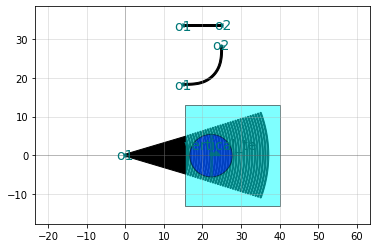

grid_d9610e5f: uid 61, ports [], aliases [(0, 0), (1, 0), (2, 0)], 0 polygons, 3 references

In [19]:
# lets create a sample PDK (for demo purposes only) using GDSfactory
# if the PDK is in a commercial tool you can also do this. Make sure you save a single pdk.gds
sample_pdk_cells = gf.grid(
    [
        gf.components.straight,
        gf.components.bend_euler,
        gf.components.grating_coupler_elliptical,
    ]
)
sample_pdk_cells.write_gds("extra/pdk.gds")
sample_pdk_cells

In [20]:
sample_pdk_cells.get_dependencies()

{bend_euler: uid 65, ports ['o1', 'o2'], aliases [], 1 polygons, 0 references,
 grating_coupler_elliptical: uid 67, ports ['vertical_te', 'o1'], aliases [], 32 polygons, 1 references,
 straight: uid 63, ports ['o1', 'o2'], aliases [], 1 polygons, 0 references}

In [21]:
# we write the sample PDK into a single GDS file
gf.clear_cache()
gf.write_cells.write_cells(gdspath="extra/pdk.gds", dirpath="extra/gds")

2022-05-02 16:31:50.885 | INFO     | gdsfactory.write_cells:write_cells:111 - Write GDS to extra/gds/grid_d9610e5f.gds


2022-05-02 16:31:50.887 | INFO     | gdsfactory.write_cells:write_cells_recursively:64 - Write GDS to extra/gds/grating_coupler_elliptical.gds


2022-05-02 16:31:50.888 | INFO     | gdsfactory.write_cells:write_cells_recursively:64 - Write GDS to extra/gds/circle_925ccccf.gds


2022-05-02 16:31:50.889 | INFO     | gdsfactory.write_cells:write_cells_recursively:64 - Write GDS to extra/gds/straight.gds


2022-05-02 16:31:50.890 | INFO     | gdsfactory.write_cells:write_cells_recursively:64 - Write GDS to extra/gds/bend_euler.gds


In [22]:
# Lets generate the script that we need to have to each GDS cell into gdsfactory

import gdsfactory as gf

print(gf.write_cells.get_import_gds_script("extra/gds"))


from pathlib import PosixPath
from functools import partial
import gdsfactory as gf

add_ports_optical = gf.partial(gf.add_ports.add_ports_from_markers_inside, pin_layer=(1, 0), port_layer=(2, 0))
add_ports_electrical = gf.partial(gf.add_ports.add_ports_from_markers_inside, pin_layer=(41, 0), port_layer=(1, 0))
add_ports = gf.compose(add_ports_optical, add_ports_electrical)


gdsdir = PosixPath('/home/runner/work/gdsfactory/gdsfactory/docs/notebooks/extra/gds')

import_gds = partial(gf.import_gds, gdsdir=gdsdir, decorator=add_ports)

bend_euler = partial(import_gds, 'bend_euler.gds')
circle_925ccccf = partial(import_gds, 'circle_925ccccf.gds')
grating_coupler_elliptical = partial(import_gds, 'grating_coupler_elliptical.gds')
grid_d9610e5f = partial(import_gds, 'grid_d9610e5f.gds')
straight = partial(import_gds, 'straight.gds')
